In [7]:
import ast
import os
import itertools
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [8]:
games = pd.read_csv("Data/games_detailed_info.csv", index_col=0) # review stats
n_rows, n_cols = games.shape

In [9]:
# 1. Remove columns with > 20% of NA values 
na_threshold = 0.2
key_columns = [colname for colname in games.columns if games[colname].isna().sum() <= na_threshold*n_rows]


In [10]:
# 2. Remove redundant/unnecesary columns
unnecessary_columns = ["type", "thumbnail", "image", "suggested_num_players", "suggested_playerage", 
                       "suggested_language_dependence"]
key_columns = [x for x in key_columns if x not in unnecessary_columns]

In [11]:
# 3. Rename confusing column names
games = games.loc[:,key_columns]
games.rename(columns={"primary": "name", "usersrated": "numratings", "average": "avgrating",
                      "boardgamecategory": "category", "boardgamemechanic": "mechanic", 
                      "boardgamedesigner": "designer", "boardgamepublisher": "publisher", 
                      "bayesaverage": "bayesavgrating", "Board Game Rank": "rank", 
                      "stddev": "stdrating", "median": "medianrating",
                      "owned": "numowned", "trading": "numtrades", "wanting":"numwants", 
                      "wishing": "numwishes"}, inplace=True)

In [12]:
# 4. Parse columns with list values
# Convert list of strings to list
for list_col in ["category", "mechanic", "designer", "publisher"]:
    games[list_col] = games[list_col].apply(lambda x: ast.literal_eval(x) if not(pd.isna(x)) else [])

In [13]:
games.columns

Index(['id', 'name', 'description', 'yearpublished', 'minplayers',
       'maxplayers', 'playingtime', 'minplaytime', 'maxplaytime', 'minage',
       'category', 'mechanic', 'designer', 'publisher', 'numratings',
       'avgrating', 'bayesavgrating', 'rank', 'stdrating', 'medianrating',
       'numowned', 'numtrades', 'numwants', 'numwishes', 'numcomments',
       'numweights', 'averageweight'],
      dtype='object')

In [14]:
df = games.sort_values('numowned', ascending= False)

In [15]:
#top 10 most owned board games
print(list(i for i in df['name'][:10]))

['Pandemic', 'Catan', 'Carcassonne', '7 Wonders', 'Codenames', 'Dominion', 'Ticket to Ride', 'Love Letter', '7 Wonders Duel', 'King of Tokyo']


In [16]:
from plottings import plot_barplot


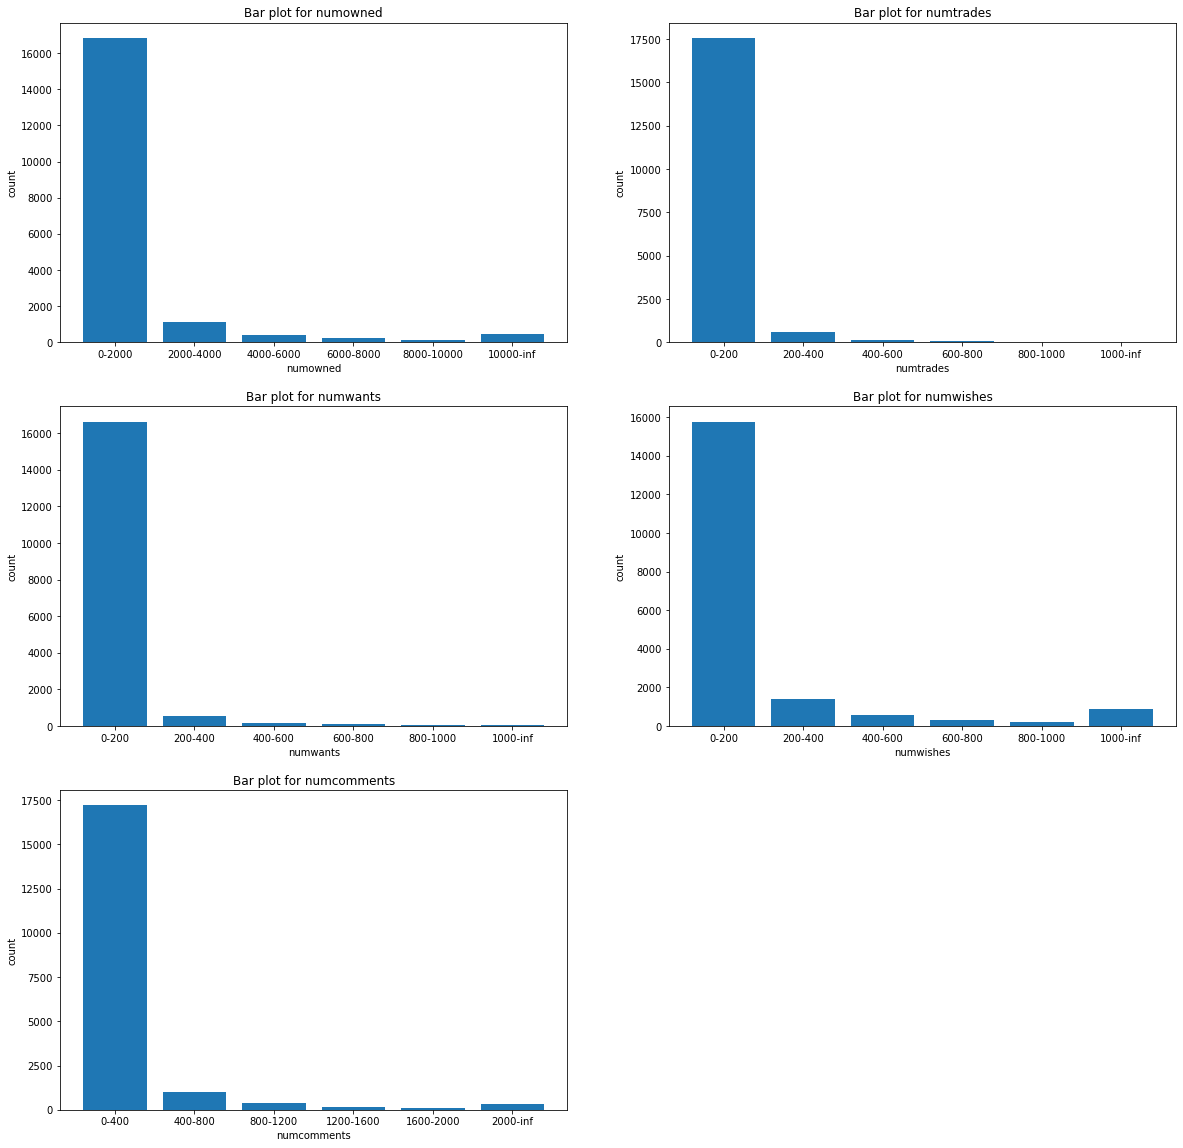

In [17]:
#visualize the numerical values
f = plt.figure(figsize=(20,20))

bins = list(range(0,10001, 2000))
bins.append(np.inf)
ax1 = f.add_subplot(321)
plot_barplot(df, 'numowned', bins)

bins = list(range(0,1001, 200))
bins.append(np.inf)
ax2 = f.add_subplot(322)
plot_barplot(df, 'numtrades', bins)

bins = list(range(0,1001, 200))
bins.append(np.inf)
ax3 = f.add_subplot(323)
plot_barplot(df, 'numwants', bins)

bins = list(range(0,1001, 200))
bins.append(np.inf)
ax4 = f.add_subplot(324)
plot_barplot(df, 'numwishes', bins)

bins = list(range(0,2001, 400))
bins.append(np.inf)
ax5 = f.add_subplot(325)
plot_barplot(df, 'numcomments', bins)

plt.show()

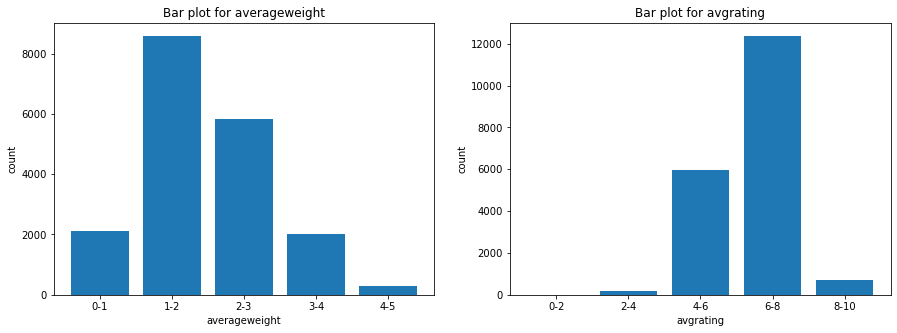

In [18]:
#visualize difficulties and ratings distribution
f2 = plt.figure(figsize=(15,5))

bins = list(range(0,6, 1))
ax1 = f2.add_subplot(121)
plot_barplot(df, 'averageweight', bins)

bins = list(range(0,11, 2))
ax2 = f2.add_subplot(122)
plot_barplot(df, 'avgrating', bins)

plt.show()

In [19]:
from plottings import correlation_plot


#gathering columns with numerical values
df2 = df[['yearpublished', 'minplayers',
       'maxplayers', 'playingtime', 'minplaytime', 'maxplaytime', 'minage',
        'numratings',
       'avgrating', 'bayesavgrating', 'rank', 
       'numowned', 'numtrades', 'numwants', 'numwishes', 'numcomments',
       'numweights', 'averageweight']]

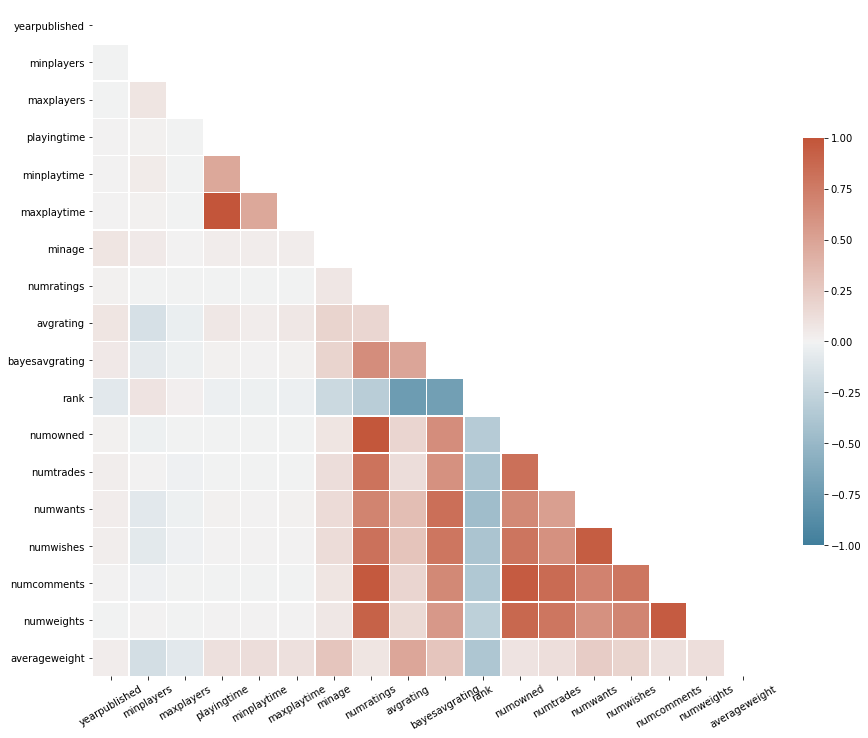

In [20]:
fig = plt.figure(figsize=(15,15))
correlation_plot(df2)

In [21]:
from word_cloud import processing_columns
from word_cloud import plot_word_cloud

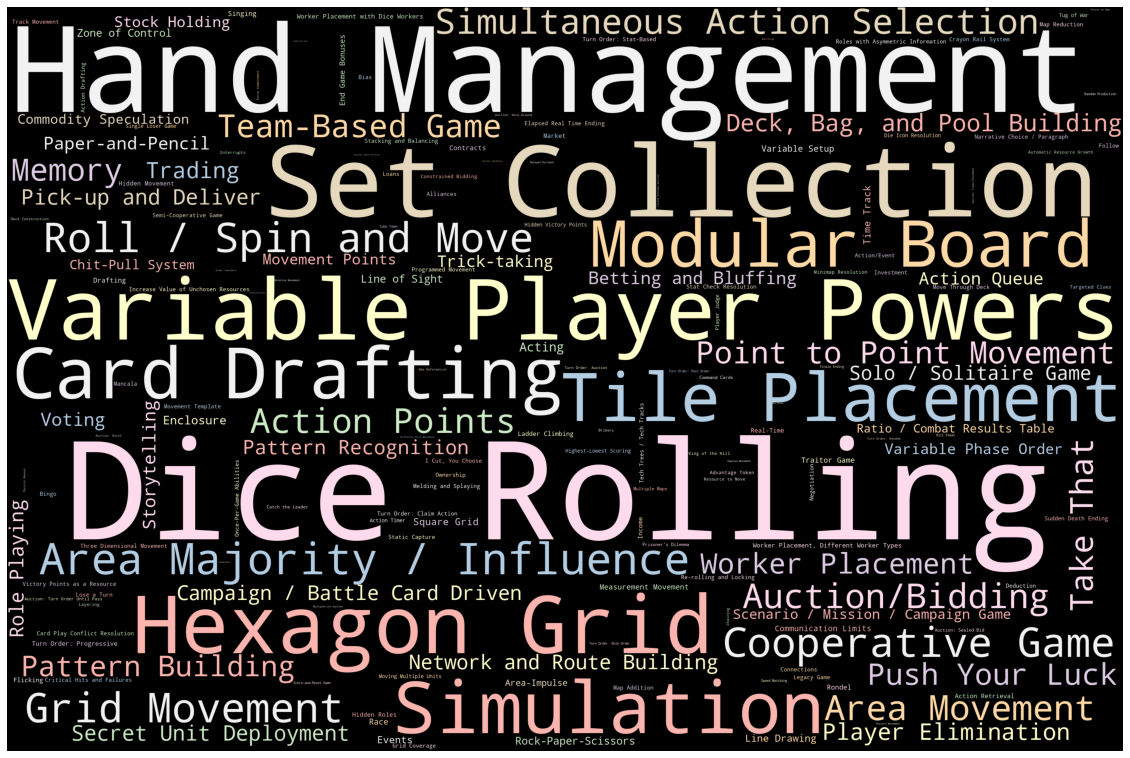

In [26]:
mechanics_count = processing_columns(df['mechanic'])
plot_word_cloud(mechanics_count)

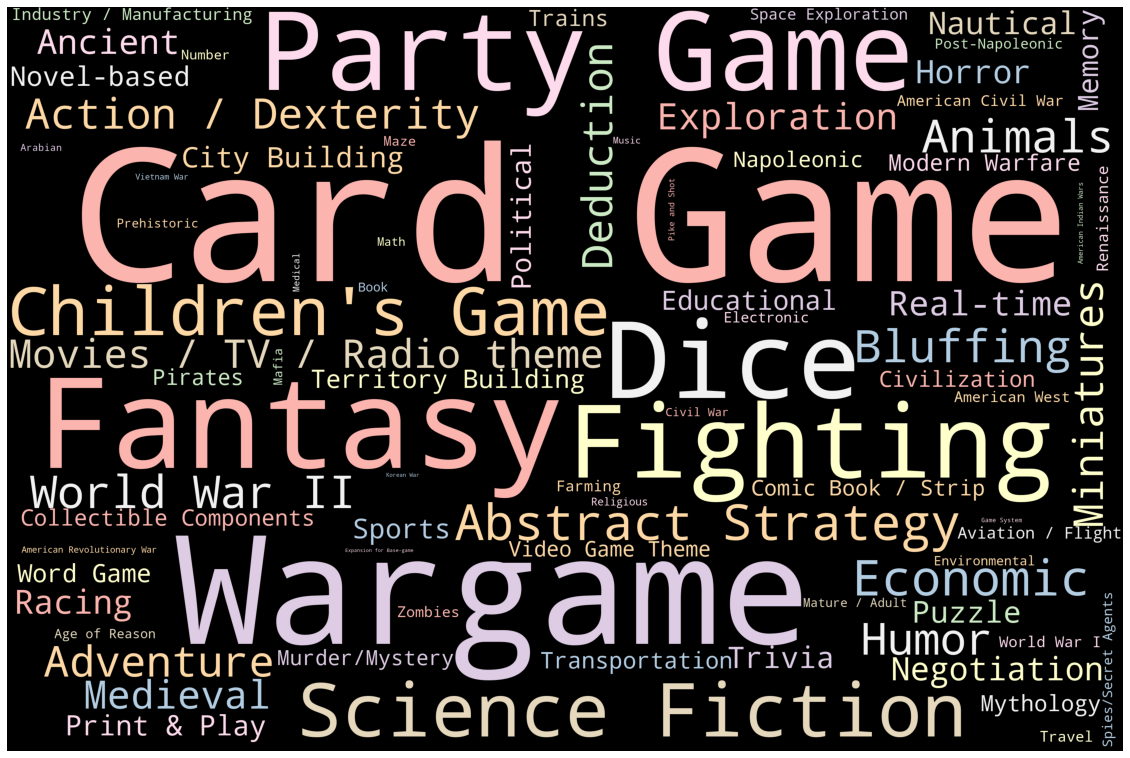

In [27]:
category_count = processing_columns(df['category'])
plot_word_cloud(category_count)

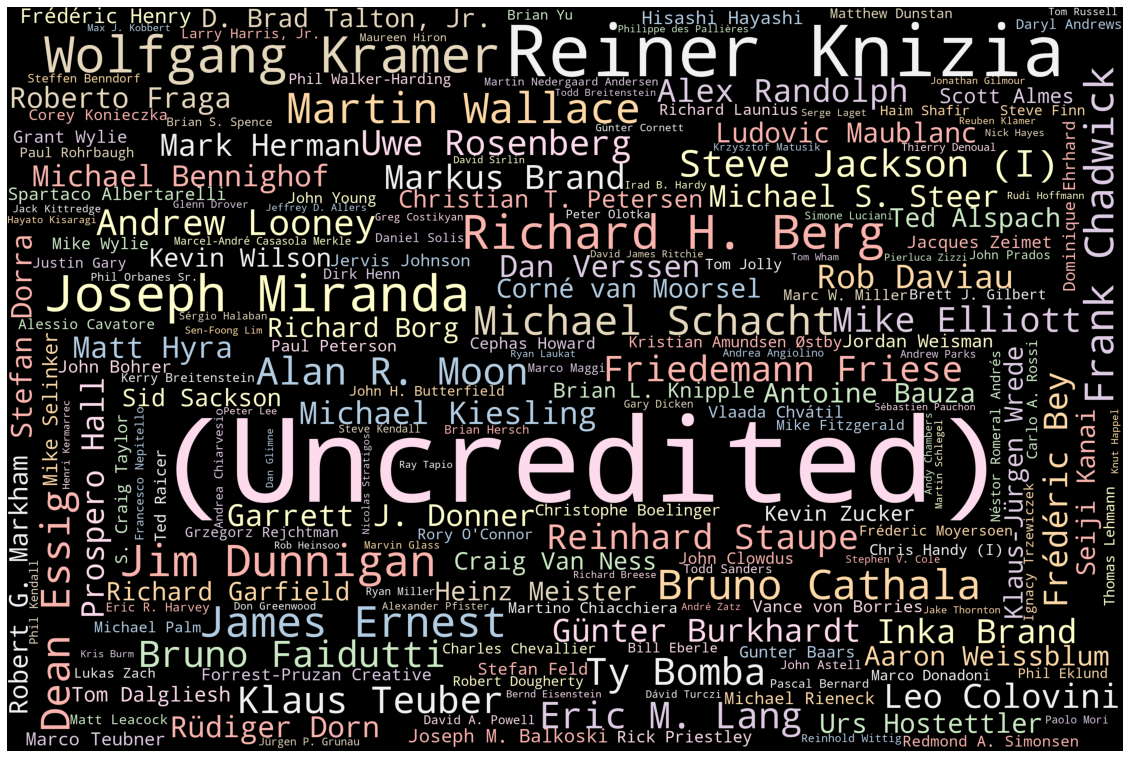

In [18]:
designer_count = processing_columns(df['designer'])
plot_word_cloud(designer_count)

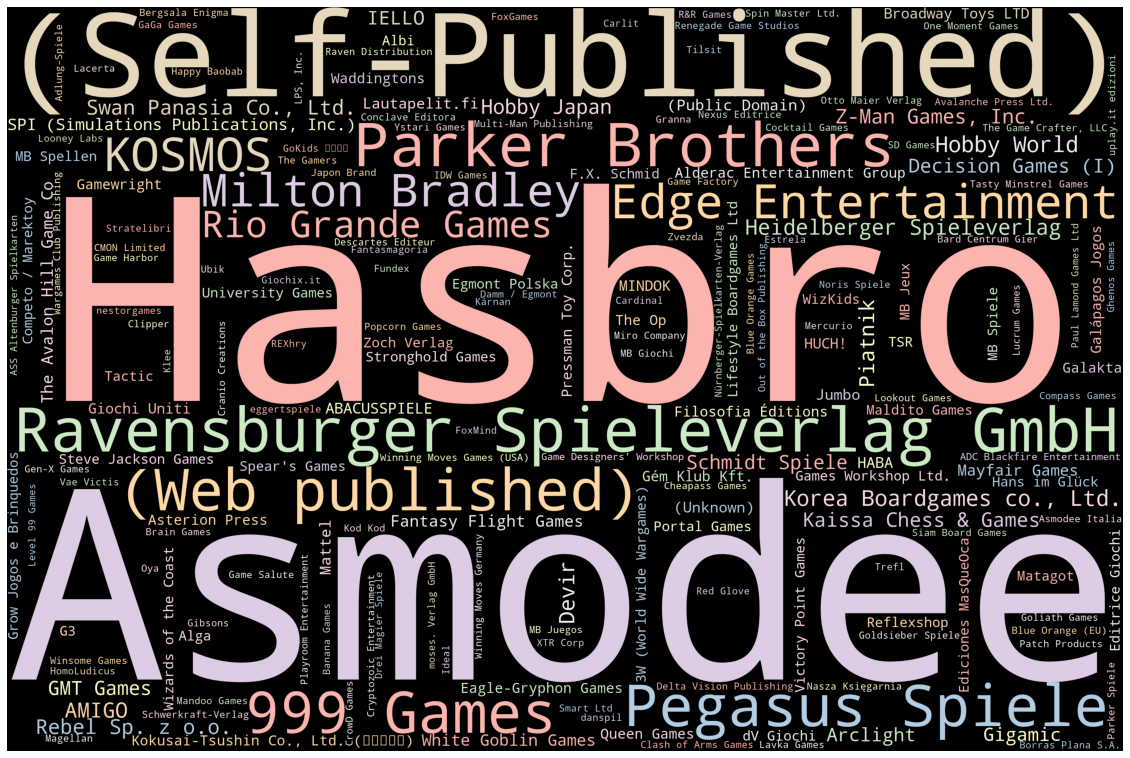

In [19]:
publisher_count = processing_columns(df['publisher'])
plot_word_cloud(publisher_count)

In [20]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import filter as ft


sm1 = widgets.SelectMultiple(
    options=ft.available_choices(games, 'mechanic'),
    description='mechanic',
    disabled=False,
)

sm2 = widgets.SelectMultiple(
     options=ft.available_choices(games, 'category'),
     description='category',
     disabled=False,
)

sm3 = widgets.SelectMultiple(
    options=ft.available_choices(games, 'publisher'),
    description='publisher',
    disabled=False,
)

sm4 = widgets.SelectMultiple(
    options=ft.available_choices(games, 'designer'),
    description='designer',
    disabled=False,
)



def output_from_sm(sm):
    return (sm.description, ', '.join(sm.value))


def filtering(df, sm1, sm2, sm3, sm4):
    
    
    for i in [sm1, sm2, sm3, sm4]:
        if len(i.value)>0:
            df = ft.rating_filter(df, output_from_sm(i)[0], output_from_sm(i)[1])
        else: continue
        
    return df



btn1 = widgets.Button(description = "Select")
btn2 = widgets.Button(description = 'Clear Output')
output = widgets.Output()
display(sm1, sm2, sm3, sm4, btn1, btn2, output)


def generate_recommendations(b):
    with output:
        x = filtering(games, sm1, sm2, sm3, sm4)
        ss = ft.select_next_n(x)
        z = next(ss)
        
        ft.display_info(z)
        
def clear(b):
    with output:
        sm1.value = ()
        sm2.value = ()
        sm3.value = ()
        sm4.value = ()
        clear_output()
        
btn1.on_click(generate_recommendations)
btn2.on_click(clear)




SelectMultiple(description='mechanic', options=('Hot Potato', 'Hand Management', 'Delayed Purchase', 'Real-Tim…

SelectMultiple(description='category', options=('Medieval', 'Mature / Adult', 'Mafia', 'Game System', 'Video G…

SelectMultiple(description='publisher', options=('Super Mega Games', 'Hill Gaming Company', 'Benassi Enterpris…

SelectMultiple(description='designer', options=('Tommaso Bonetti', 'Mark Sherry', 'Michael Sewall', 'Sandie Ri…

Button(description='Select', style=ButtonStyle())

Button(description='Clear Output', style=ButtonStyle())

Output()